# **Name: Jay Bhanushali**

# **SAP: 60009200047**

# **Batch: K2**

In [159]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 6, 6

In [160]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

# **Breast cancer dataset (Naive Bayes from scratch)**

In [161]:
data = pd.read_csv('/content/Breast_cancer_data.csv')
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [163]:
data.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


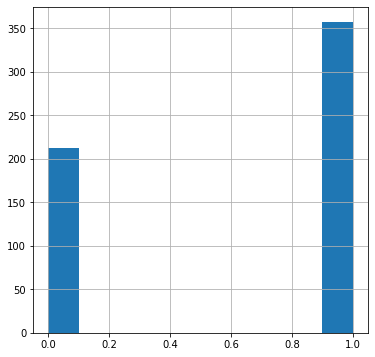

In [164]:
data.diagnosis.hist()

This shows that there is slight imbalance between data because we have more values of *B* as compared to *M*

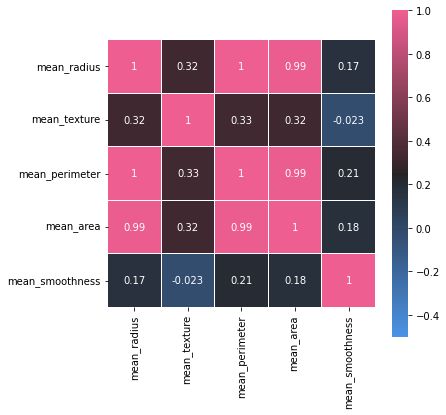

In [165]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-0.5, cmap=cmap,annot=True ,square=True, linewidths=0.2)

* From the above heat map it is clear that there is very high correlation between ```[mean_radius, mean_parimeter, mean_area] ``` 

* let's select one ```mean_radius``` column from these correlated features.

In [166]:
selected_cols = ['mean_radius','mean_texture','mean_smoothness','diagnosis']
df = data[selected_cols]

In [167]:
df

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
...,...,...,...,...
564,21.56,22.39,0.11100,0
565,20.13,28.25,0.09780,0
566,16.60,28.08,0.08455,0
567,20.60,29.33,0.11780,0


Plotting histogram to look at distribution of data

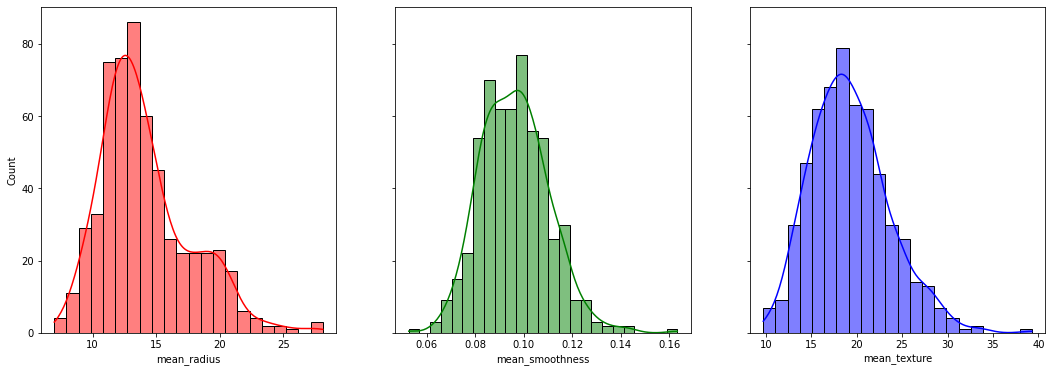

In [168]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='g')
sns.histplot(data, ax=axes[2], x="mean_texture", color='b', kde=True)

**Data is *almost* normally distributed**







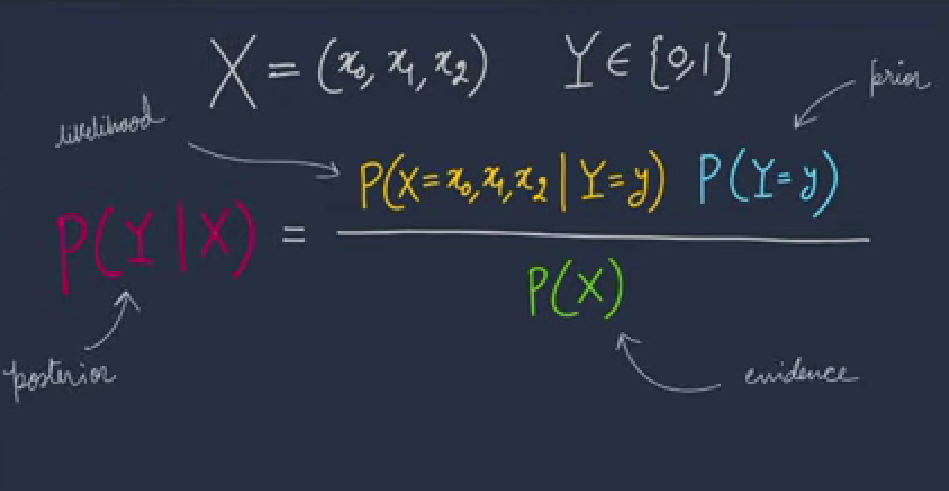

Calculate P(Y=y) for all possible values of y

In [169]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))

    return prior

In [170]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))

    return p_x_given_y

In [171]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [172]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [173]:
y_pred_test = naive_bayes_gaussian(df, X=X_test, Y="diagnosis")
y_pred_train = naive_bayes_gaussian(df, X=X_train, Y="diagnosis")

In [174]:
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(train_acc*100, test_acc*100)

90.20100502512562 94.73684210526315


In [175]:
cm = confusion_matrix(y_test, y_pred_test)
cm

array([[ 55,   8],
       [  1, 107]])

# **Using sklearn**

## Social_Networking_Ads 

In [177]:
data = pd.read_csv('/content/Social_Network_Ads.csv')
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [178]:
X = data.iloc[:, [1,2,3]]
y = data.iloc[:, -1]
X

,Gender,Age,EstimatedSalary
0,Male,19,19000
1,Male,35,20000
2,Female,26,43000
3,Female,27,57000
4,Male,19,76000
...,...,...,...
395,Female,46,41000
396,Male,51,23000
397,Female,50,20000
398,Male,36,33000


In [179]:
le = LabelEncoder()
X.Gender = le.fit_transform(X.Gender) # Gender column
X

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Gender,Age,EstimatedSalary
0,1,19,19000
1,1,35,20000
2,0,26,43000
3,0,27,57000
4,1,19,76000
...,...,...,...
395,0,46,41000
396,1,51,23000
397,0,50,20000
398,1,36,33000


In [180]:
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[ 1.02020406, -1.78179743, -1.49004624],
       [ 1.02020406, -0.25358736, -1.46068138],
       [-0.98019606, -1.11320552, -0.78528968],
       ...,
       [-0.98019606,  1.17910958, -1.46068138],
       [ 1.02020406, -0.15807423, -1.07893824],
       [-0.98019606,  1.08359645, -0.99084367]])

In [181]:
pd.DataFrame(X).describe

<bound method NDFrame.describe of             0         1         2
0    1.020204 -1.781797 -1.490046
1    1.020204 -0.253587 -1.460681
2   -0.980196 -1.113206 -0.785290
3   -0.980196 -1.017692 -0.374182
4    1.020204 -1.781797  0.183751
..        ...       ...       ...
395 -0.980196  0.797057 -0.844019
396  1.020204  1.274623 -1.372587
397 -0.980196  1.179110 -1.460681
398  1.020204 -0.158074 -1.078938
399 -0.980196  1.083596 -0.990844

[400 rows x 3 columns]>

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [183]:
X_train.shape

(280, 3)

In [184]:
X_test.shape

(120, 3)

In [185]:
model = GaussianNB()
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [186]:
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(train_acc*100, test_acc*100)

86.42857142857143 90.83333333333333


In [187]:
cm = confusion_matrix(y_test, y_pred_test)
cm

array([[71,  2],
       [ 9, 38]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


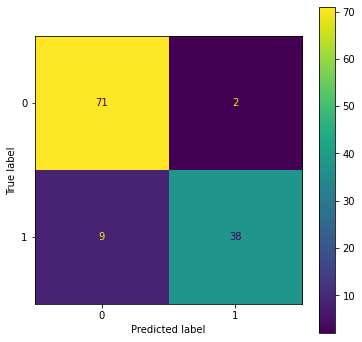

In [188]:
plot_confusion_matrix(model, X_test, y_test)

## German creditcard dataset

In [189]:
data = pd.read_csv('/content/german_credit_data.csv')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [191]:
data.drop(['Unnamed: 0'],axis=1, inplace=True)

In [192]:
data.columns = data.columns.str.replace(' ','_')

In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving_accounts   817 non-null    object
 5   Checking_account  606 non-null    object
 6   Credit_amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


As there is vess little to no corellation among all features we can select all of them

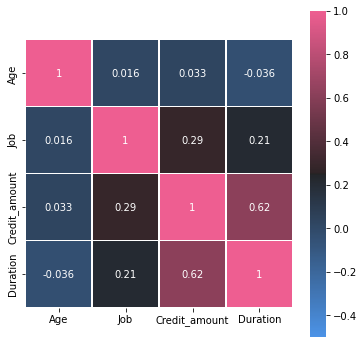

In [194]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-0.5, cmap=cmap, annot=True, square=True, linewidths=0.2)

In [195]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,40,male,3,own,little,little,3857,30,car
997,38,male,2,own,little,NaN,804,12,radio/TV
998,23,male,2,free,little,little,1845,45,radio/TV


In [196]:
y

0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: Risk, Length: 1000, dtype: object

In [197]:
X = X.apply(LabelEncoder().fit_transform)
X.head(10)

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose
0,48,1,2,1,4,0,142,2,5
1,3,0,2,1,0,1,770,29,5
2,30,1,1,1,0,3,390,8,3
3,26,1,2,0,0,0,848,26,4
4,34,1,2,0,0,0,734,17,1
5,16,1,1,0,4,3,869,23,3
6,34,1,2,1,2,3,533,17,4
7,16,1,3,2,0,1,813,23,1
8,42,1,1,1,3,3,562,8,5
9,9,1,3,1,0,1,747,21,1


In [198]:
y = pd.Series(LabelEncoder().fit_transform(y),name="Risk")
y

0      1
1      0
2      1
3      1
4      0
      ..
995    1
996    1
997    1
998    0
999    1
Name: Risk, Length: 1000, dtype: int64

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape)
print(y_test.shape, y_test.shape)

(700, 9) (700,)
(300,) (300,)


In [200]:
model = GaussianNB()
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [201]:
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
print(train_acc*100, test_acc*100)

74.71428571428571 76.0


In [202]:
cm = confusion_matrix(y_test, y_pred_test)
cm

array([[ 50,  36],
       [ 36, 178]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


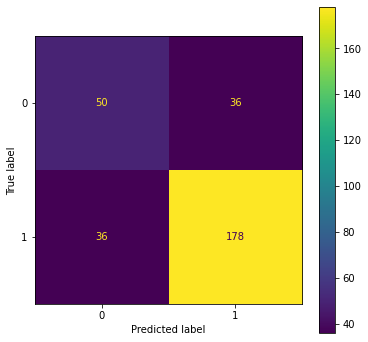

In [203]:
plot_confusion_matrix(model, X_test, y_test)